In [1]:
import pandas as pd 
from pandas import Series
import numpy as np 
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.api import qqplot  
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson


from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX 

import pmdarima as pm
from pmdarima import auto_arima 
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import nsdiffs
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn import datasets

# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 

In [2]:
#Importing data
Shenyang = pd.read_csv("D:/Math546 Time series/final projects/PM2.5 Data of Five Chinese Cities Data Set/ShenyangPM20100101_20151231.csv")

In [26]:
#Delet non-useful data
##Beijing.drop(['PM_Dongsi', 'PM_Dongsihuan', 'PM_Nongzhanguan', 'season', 'precipitation', 'Iprec'], 
##               axis=1,
##              inplace=True)

In [27]:
Beijing.dropna(axis=0, how="any",inplace=True)

In [3]:
# from datetime import datetime
Shenyang['Time'] = pd.to_datetime(Shenyang['year'].map(str) +"/"+ Shenyang['month'].map(str) +"/"+ Shenyang['day'].map(str)+" "+Shenyang['hour'].map(str)+":00:00")
#Shenyang

In [4]:
Shenyang.groupby(['year']).size()

year
2010    8760
2011    8760
2012    8784
2013    8760
2014    8760
2015    8760
dtype: int64

In [5]:
by_hour = Shenyang.groupby(['Time']).mean()
print(by_hour.head())

                     No  year  month  day  hour  season  PM_Taiyuanjie  \
Time                                                                     
2010-01-01 00:00:00   1  2010      1    1     0       4            NaN   
2010-01-01 01:00:00   2  2010      1    1     1       4            NaN   
2010-01-01 02:00:00   3  2010      1    1     2       4            NaN   
2010-01-01 03:00:00   4  2010      1    1     3       4            NaN   
2010-01-01 04:00:00   5  2010      1    1     4       4            NaN   

                     PM_US Post  PM_Xiaoheyan  DEWP   HUMI    PRES  TEMP  \
Time                                                                       
2010-01-01 00:00:00         NaN           NaN -26.0  69.79  1024.0 -22.0   
2010-01-01 01:00:00         NaN           NaN -26.0  76.26  1024.0 -23.0   
2010-01-01 02:00:00         NaN           NaN -27.0  69.56  1023.0 -23.0   
2010-01-01 03:00:00         NaN           NaN -27.0  69.56  1023.0 -23.0   
2010-01-01 04:00:00      

In [6]:
by_hour.index = pd.to_datetime(by_hour.index, 
                             format='%d-%m-%Y %H:%M:%S')
by_hour = by_hour.set_index(by_hour.index).asfreq('H')
by_hour = by_hour.fillna(method='ffill')

print(by_hour.index)

DatetimeIndex(['2010-01-01 00:00:00', '2010-01-01 01:00:00',
               '2010-01-01 02:00:00', '2010-01-01 03:00:00',
               '2010-01-01 04:00:00', '2010-01-01 05:00:00',
               '2010-01-01 06:00:00', '2010-01-01 07:00:00',
               '2010-01-01 08:00:00', '2010-01-01 09:00:00',
               ...
               '2015-12-31 14:00:00', '2015-12-31 15:00:00',
               '2015-12-31 16:00:00', '2015-12-31 17:00:00',
               '2015-12-31 18:00:00', '2015-12-31 19:00:00',
               '2015-12-31 20:00:00', '2015-12-31 21:00:00',
               '2015-12-31 22:00:00', '2015-12-31 23:00:00'],
              dtype='datetime64[ns]', name='Time', length=52584, freq='H')


In [7]:
by_hour['Time'] = by_hour.index
by_hour['Time']

Time
2010-01-01 00:00:00   2010-01-01 00:00:00
2010-01-01 01:00:00   2010-01-01 01:00:00
2010-01-01 02:00:00   2010-01-01 02:00:00
2010-01-01 03:00:00   2010-01-01 03:00:00
2010-01-01 04:00:00   2010-01-01 04:00:00
                              ...        
2015-12-31 19:00:00   2015-12-31 19:00:00
2015-12-31 20:00:00   2015-12-31 20:00:00
2015-12-31 21:00:00   2015-12-31 21:00:00
2015-12-31 22:00:00   2015-12-31 22:00:00
2015-12-31 23:00:00   2015-12-31 23:00:00
Freq: H, Name: Time, Length: 52584, dtype: datetime64[ns]

In [22]:
data_13 = by_hour[(by_hour['Time'] >=pd.to_datetime('20140101030000')) & (by_hour['Time'] <= pd.to_datetime('20151231030000'))]

In [23]:
data_13 = data_13.set_index(data_13.index).asfreq('d')

In [16]:
data = by_hour[(by_hour['Time'] >=pd.to_datetime('20140101030000')) & (by_hour['Time'] <= pd.to_datetime('20140112030000'))]
data = data.set_index(data.index).asfreq('H')
#data

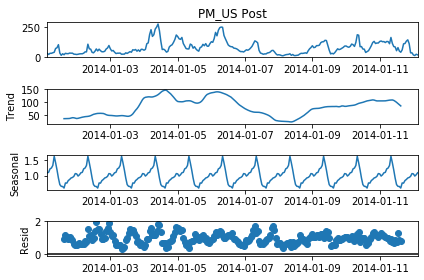

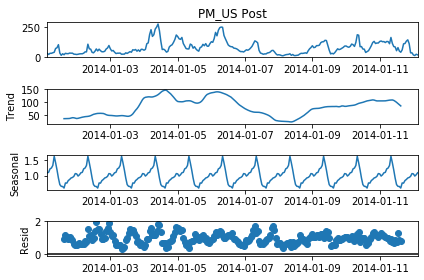

In [17]:
result = seasonal_decompose(data['PM_US Post'],  
                            model ='multiplicative') 
  
# ETS plot  
result.plot()

In [18]:
len(data_13)

731

In [24]:
# Split data into train / test sets 
train = data_13['PM_US Post'].iloc[:len(data_13)-156] 
test = data_13['PM_US Post'].iloc[len(data_13)-156:]

In [25]:
# Fit auto_arima function to dataset 
stepwise_fit = auto_arima(data_13['PM_US Post'], start_p = 0, start_q = 0, 
                          max_p = 4, max_q = 4, m=7,
                          start_P = 0, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise  

Performing stepwise search to minimize aic
Fit ARIMA: (0, 0, 0)x(0, 1, 1, 7) (constant=True); AIC=8267.245, BIC=8280.995, Time=0.328 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 7) (constant=True); AIC=8626.713, BIC=8635.880, Time=0.029 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 0, 7) (constant=True); AIC=8365.892, BIC=8384.225, Time=0.447 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 1, 7) (constant=True); AIC=8182.917, BIC=8201.251, Time=0.886 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 7) (constant=False); AIC=8624.725, BIC=8629.309, Time=0.018 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 0, 7) (constant=True); AIC=8577.311, BIC=8591.061, Time=0.251 seconds
Fit ARIMA: (0, 0, 1)x(1, 1, 1, 7) (constant=True); AIC=8189.607, BIC=8212.524, Time=0.716 seconds
Near non-invertible roots for order (0, 0, 1)(1, 1, 1, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 0, 1)x(0, 1, 2, 7) (constant=True); AIC=8191.117, BIC=8214.034, Time=1.313 seconds
Near non-inver

In [26]:
# To print the summary 
stepwise_fit.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  730
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 7)   Log Likelihood               -4087.459
Date:                           Fri, 10 Apr 2020   AIC                           8182.917
Time:                                   18:40:31   BIC                           8201.251
Sample:                                        0   HQIC                          8189.994
                                           - 730                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1518      0.684      0.222      0.824      -1.188       1.491
ma.L1          0.3750      0.020     19.014      0.000       0.336       0.414
ma.S.L7       -0.8686      0.021    -41.578      0.000      -0.910      -0.828
sigma2      4700.7561    118.145     39.788      0.000    4469.195    4932.317
===================================================================================
Ljung-Box (Q):                      105.86   Jarque-Bera (JB):              5653.24
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                             2.40
Prob(H) (two-sided):                  0.79   Kurtosis:                        15.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
# Fit a SARIMAX(0, 0, 1)x(0, 1, 1, 7)on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(train,  
                order = (0, 0, 1),  
                seasonal_order =(0, 1, 1, 7))

In [33]:
result = model.fit() 

In [34]:
 result.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                        PM_US Post   No. Observations:                  574
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 7)   Log Likelihood               -3210.800
Date:                           Fri, 10 Apr 2020   AIC                           6427.601
Time:                                   18:40:58   BIC                           6440.622
Sample:                               01-01-2014   HQIC                          6432.682
                                    - 07-28-2015                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3746      0.021     17.610      0.000       0.333       0.416
ma.S.L7       -0.9940      0.057    -17.386      0.000      -1.106      -0.882
sigma2      4623.2118    232.529     19.882      0.000    4167.463    5078.961
===================================================================================
Ljung-Box (Q):                      173.87   Jarque-Bera (JB):              6906.96
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.30   Skew:                             2.86
Prob(H) (two-sided):                  0.07   Kurtosis:                        19.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

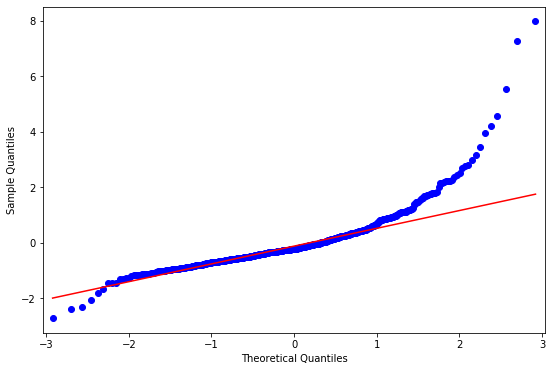

In [35]:
resid = result.resid
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
qqplot(resid, line='q', ax=ax, fit=True)
plt.show()

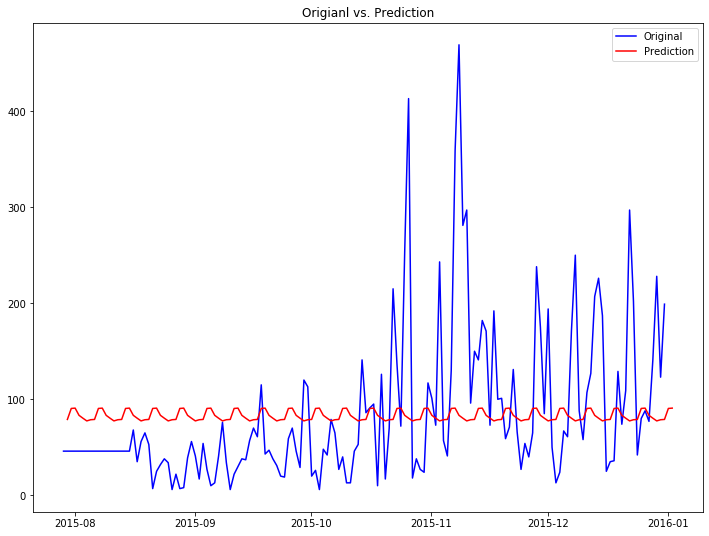

In [36]:
predict_ARMA = result.predict(start =575, end = 731) 
#print(predict_ARIMA) 

plt.figure(figsize=(12,9)) 
orig = plt.plot(test, color='blue', label='Original') 
pred = plt.plot(predict_ARMA, color='red', label='Prediction' ) 
plt.legend(loc='best') 
plt.title('Origianl vs. Prediction') 
plt.show(block=False) 